In [25]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ankushpanday2/colorectal-cancer-global-dataset-and-predictions")

print("Path to dataset files:", path)

100%|██████████| 3.93M/3.93M [00:00<00:00, 90.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ankushpanday2/colorectal-cancer-global-dataset-and-predictions/versions/1


In [4]:
cancer = pd.read_csv(f"{path}/colorectal_cancer_dataset.csv")
cancer.head()

,Patient_ID,Country,Age,Gender,Cancer_Stage,Tumor_Size_mm,Family_History,Smoking_History,Alcohol_Consumption,Obesity_BMI,...,Survival_5_years,Mortality,Healthcare_Costs,Incidence_Rate_per_100K,Mortality_Rate_per_100K,Urban_or_Rural,Economic_Classification,Healthcare_Access,Insurance_Status,Survival_Prediction
0,1,UK,77,M,Localized,69,No,No,Yes,Overweight,...,Yes,No,54413,50,5,Urban,Developed,Moderate,Insured,Yes
1,2,UK,59,M,Localized,33,No,No,No,Overweight,...,Yes,No,76553,37,25,Urban,Developing,High,Uninsured,Yes
2,3,Japan,66,M,Regional,17,No,Yes,No,Normal,...,Yes,No,62805,54,27,Urban,Developed,Moderate,Uninsured,No
3,4,USA,83,M,Regional,14,No,No,No,Obese,...,Yes,No,89393,45,11,Urban,Developed,Moderate,Insured,Yes
4,5,France,66,M,Localized,34,No,Yes,No,Normal,...,Yes,No,66425,15,27,Urban,Developing,High,Insured,Yes


In [5]:
binary_mappings = {
    'Gender': {'F': 1, 'M': 0},
    'Alcohol_Consumption': {'Yes': 1, 'No': 0},
    'Smoking_History': {'Yes': 1, 'No': 0},
    'Survival_Prediction': {'Yes': 1, 'No': 0},
    'Insurance_Status': {'Insured': 1, 'Uninsured': 0},
    'Economic_Classification': {'Developed': 1, 'Developing': 0},
    'Urban_or_Rural': {'Urban': 1, 'Rural': 0},
    'Mortality': {'Yes': 1, 'No': 0},
    'Family_History': {'Yes': 1, 'No': 0}
}

for col, mapping in binary_mappings.items():
    cancer[col] = cancer[col].map(mapping)
cancer = cancer.select_dtypes(include=['int64', 'float64'])
# Удаление строк с пропущенными значениями
cancer = cancer.dropna()


In [6]:
#делим на X и Y
Y = cancer['Healthcare_Costs']
X = cancer.drop(['Healthcare_Costs'], axis=1)
print(X)


        Patient_ID  Age  Gender  Tumor_Size_mm  Family_History  \
0                1   77       0             69               0   
1                2   59       0             33               0   
2                3   66       0             17               0   
3                4   83       0             14               0   
4                5   66       0             34               0   
...            ...  ...     ...            ...             ...   
167492      167493   69       0             49               0   
167493      167494   79       1             29               1   
167494      167495   74       0             62               1   
167495      167496   68       1             35               0   
167496      167497   79       1             67               1   

        Smoking_History  Alcohol_Consumption  Mortality  \
0                     0                    1          0   
1                     0                    0          0   
2                     1       

In [9]:
# разбиение на обучающую и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [15]:
# Удаляем константные столбцы
constant_cols = [col for col in X_train.columns if X_train[col].nunique() == 1]
X_train.drop(columns=constant_cols, inplace=True)
X_test.drop(columns=constant_cols, inplace=True)

# Числовые и категориальные столбцы
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Заполняем пропуски в числовых данных медианой
if not numeric_cols.empty:
    X_train[numeric_cols] = X_train[numeric_cols].fillna(X_train[numeric_cols].median())
    X_test[numeric_cols] = X_test[numeric_cols].fillna(X_test[numeric_cols].median())

# Заполняем пропуски в категориальных данных модой (самое частое значение)
if not categorical_cols.empty:
    for col in categorical_cols:
        mode_val = X_train[col].mode()[0]  # берем первое самое частое значение
        X_train[col] = X_train[col].fillna(mode_val)
        X_test[col] = X_test[col].fillna(mode_val)

# Проверяем категориальные признаки
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Пайплайн
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


In [28]:
from tensorflow.keras import layers

In [30]:
def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Выход для регрессии
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_model(X_train_scaled.shape[1])

In [18]:
model_2 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model_2.compile(optimizer='adam', loss='mse')
model_2.fit(X_train_scaled, Y_train, epochs=50, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 3650214912.0000 - val_loss: 768508224.0000
Epoch 2/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 791219136.0000 - val_loss: 766160576.0000
Epoch 3/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 785715520.0000 - val_loss: 764889792.0000
Epoch 4/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 785213568.0000 - val_loss: 763955904.0000
Epoch 5/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 786287104.0000 - val_loss: 766032256.0000
Epoch 6/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 788043264.0000 - val_loss: 762505344.0000
Epoch 7/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 782055232.0000 - val_loss: 763117824.0000
Epoch 8/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 781027072.0000 - val_loss: 762958272.0000
Epoch 9/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 782697600.0000 - val_loss: 762496832.0000
Epoch 10/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step -

In [19]:
def build_model_3(input_shape):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model_3 = build_model_3(X_train_scaled.shape[1])
history_3 = model_3.fit(X_train_scaled, Y_train, epochs=50, batch_size=32,
                        validation_split=0.2, verbose=1)

Epoch 1/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3962862848.0000 - mae: 54275.2656 - val_loss: 759697088.0000 - val_mae: 23900.1895
Epoch 2/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 751877632.0000 - mae: 23722.7051 - val_loss: 758936000.0000 - val_mae: 23888.0762
Epoch 3/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 751252096.0000 - mae: 23709.1250 - val_loss: 758996352.0000 - val_mae: 23888.2383
Epoch 4/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 751643968.0000 - mae: 23731.5098 - val_loss: 759534016.0000 - val_mae: 23898.7012
Epoch 5/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 749985024.0000 - mae: 23702.3477 - val_loss: 760090112.0000 - val_mae: 23904.4570
Epoch 6/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 751438784.0000 - mae: 23709.9023 - val_loss: 760620032.0000 - val_mae: 23903.8711
Epoch 7/50
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 751622336.0000 - mae: 23725.5527 - val_loss: 759354560.0000 - val_mae

Модель 1:
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MSE: 6021516288.00, MAE: 72628.91, R²: -7.07

Модель 2:
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MSE: 748300864.00, MAE: 23656.58, R²: -0.00

Модель 3:
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MSE: 747044800.00, MAE: 23646.19, R²: -0.00


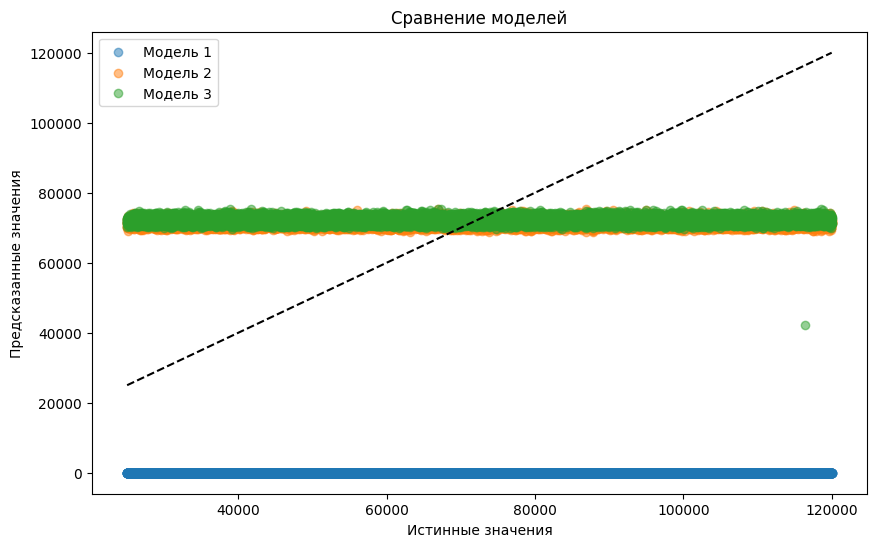

In [26]:
def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    return Y_pred

# Оценка всех моделей
print("Модель 1:")
Y_pred_1 = evaluate_model(model, X_test_scaled, Y_test)

print("\nМодель 2:")
Y_pred_2 = evaluate_model(model_2, X_test_scaled, Y_test)

print("\nМодель 3:")
Y_pred_3 = evaluate_model(model_3, X_test_scaled, Y_test)

# График True vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred_1, alpha=0.5, label='Модель 1')
plt.scatter(Y_test, Y_pred_2, alpha=0.5, label='Модель 2')
plt.scatter(Y_test, Y_pred_3, alpha=0.5, label='Модель 3')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.legend()
plt.title('Сравнение моделей')
plt.show()